In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat

In [6]:
#paths

nsd_root = "data/nsd/"
meanROIbeta_root = nsd_root + "roiavgbeta_neurogen/"
weight_root = "neurogen/output/"
exp_design_file = nsd_root + "nsd_expdesign.mat"

# base_dir = "data/synthetic_categories/"
# categories = ["animals", "foods", "landscapes", "vehicles"]

thr = 0.5
stim_num = 200
base_dir = f"data/synthetic_new_categories_ver3_{thr}/"
categories = ["animals", "foods", "humans", "places"]

controlled = ["original", "increased", "decreased"]

In [7]:
ROIs = [
    'OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces',
    'EBA', 'FBA1', 'FBA2', 'mTLbodies',
    'OPA', 'PPA', 'RSC',
    'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4',
    'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala'
]

ns_ROIs = {
    1: "FFA1",
    2: "V1d",
    5: "R-amygdala",
    6: "FBA1"
}

In [8]:
# images = np.load(base_dir+f"{categories[0]}/original_imgs_100.npy")
# images /= 255.
# plt.imshow(images[0].transpose(1, 2, 0))

In [24]:
idx = 3

## ResNet

In [25]:
subjects = [1, 2, 3, 4, 5, 6, 7, 8]

sub_pred = np.full((8, stim_num, 23), np.nan)
sub_pred_h = np.full((8, stim_num, 23), np.nan)
sub_pred_l = np.full((8, stim_num, 23), np.nan)

for i, subject in enumerate(subjects):
    sub_pred[i] = np.load(base_dir+f"{categories[idx]}/predicted_responses/S{subject:02d}_original_responses.npy")
    sub_pred_h[i] = np.load(base_dir+f"{categories[idx]}/predicted_responses/S{subject:02d}_increased_responses.npy")
    sub_pred_l[i] = np.load(base_dir+f"{categories[idx]}/predicted_responses/S{subject:02d}_decreased_responses.npy")
    # if subject in ns_ROIs.keys():
    #     print(f"subject {subject} - deleted ROI: {ns_ROIs[subject]}")
    #     del_idx = ROIs.index(ns_ROIs[subject])
    #     sub_pred[i][:, del_idx] = np.full((len(ctrld_nids),), np.nan)

pred = np.nanmean(sub_pred, axis=0)
pred_h = np.nanmean(sub_pred_h, axis=0)
pred_l = np.nanmean(sub_pred_l, axis=0)
print(pred.shape, pred_h.shape, pred_l.shape)

(200, 23) (200, 23) (200, 23)


## Histograms

### Early visual areas

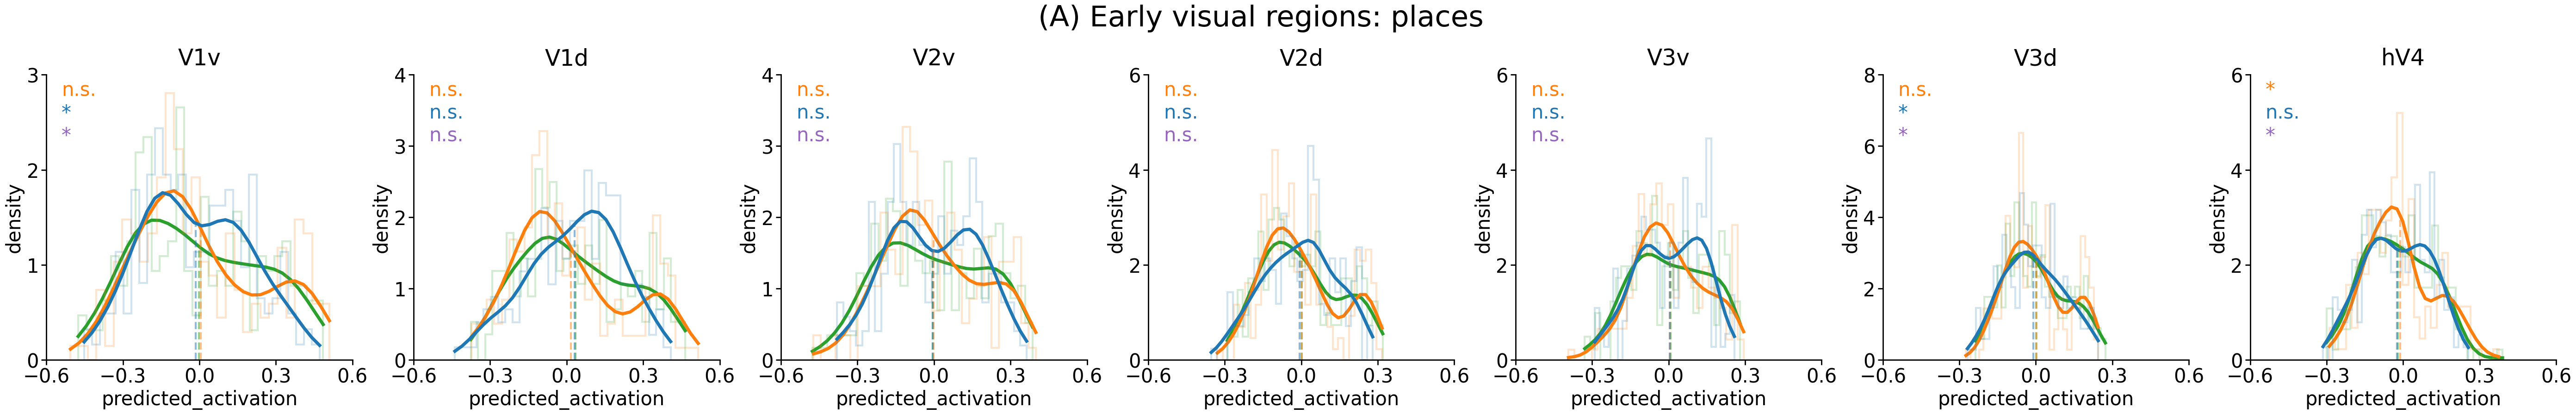

In [26]:
ev_ROIs = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
plt.figure(figsize=(70, 8))

for i, roi in enumerate(ev_ROIs):
    ax = plt.subplot2grid((1,7), (0, i))
    roi_idx = ROIs.index(roi)
    
    orig = pred[:,roi_idx]  
    high = pred_h[:,roi_idx]
    low = pred_l[:,roi_idx]
    
    _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
    _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    _, pvalue_hl = stats.ttest_rel(high, low, alternative='greater')
    
    # plot histogram
    no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    density_orig = stats.gaussian_kde(orig)
    line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    density_high = stats.gaussian_kde(high)
    line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    density_low = stats.gaussian_kde(low)
    line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # Mark the means
    mean_o = np.mean(orig)
    mean_h = np.mean(high)
    mean_l = np.mean(low)
    plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    if pvalue_h<0.001:
        ph = "***"
    elif pvalue_h<0.01:
        ph = "**"
    elif pvalue_h<0.05:
        ph = "*"
    else:
        ph = "n.s."

    if pvalue_l<0.001:
        pl = "***"
    elif pvalue_l<0.01:
        pl = "**"
    elif pvalue_l<0.05:
        pl = "*"
    else:
        pl = "n.s."

    if pvalue_hl<0.001:
        phl = "***"
    elif pvalue_hl<0.01:
        phl = "**"
    elif pvalue_hl<0.05:
        phl = "*"
    else:
        phl = "n.s."
    
    plt.title(roi, fontsize=35, pad=15)
    
    ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.82, phl, fontsize=30, color="tab:purple", ha='left', va='top', transform=ax.transAxes)
    
    plt.xticks([-0.6, -0.3, 0, 0.3, 0.6], fontsize=30)
    plt.locator_params(axis='y', nbins=4)
    labels = [float(item.get_text())for item in ax.get_yticklabels()]
    plt.yticks(labels, fontsize=30)
    
    ax.tick_params(width=2, length=8)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    ax.set_xlabel("predicted_activation", fontsize=30)
    ax.set_ylabel("density", fontsize=30)

# plt.figlegend(handles=[line_o, line_h, line_l], ncols=3, loc="upper right", fontsize=25, bbox_to_anchor=(0.91, 1.12))
plt.suptitle(f"(A) Early visual regions: {categories[idx]}", fontsize=45, y=1.07)
plt.savefig(base_dir+f"{categories[idx]}/earlyvisual_ROIs_histplots.png", bbox_inches="tight")

### Face & body areas

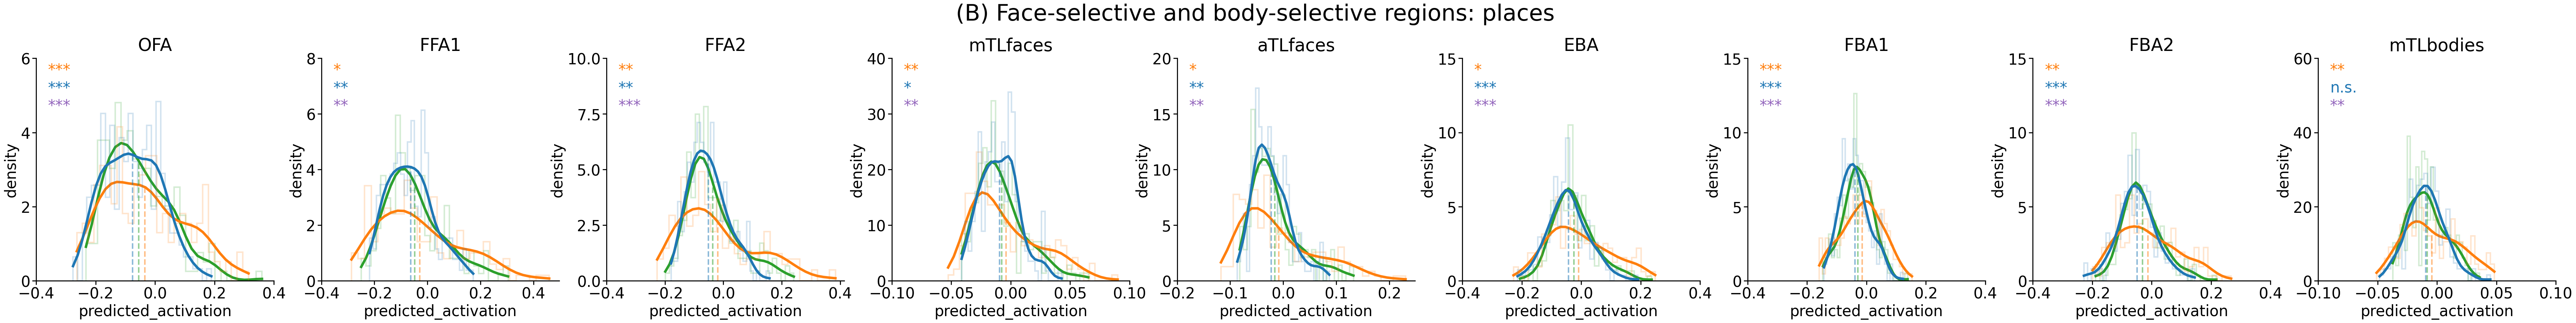

In [27]:
facebody_ROIs = ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies']
plt.figure(figsize=(90, 8))

for i, roi in enumerate(facebody_ROIs):
    ax = plt.subplot2grid((1,9), (0, i))
    roi_idx = ROIs.index(roi)
    
    orig = pred[:,roi_idx]  
    high = pred_h[:,roi_idx]
    low = pred_l[:,roi_idx]
    
    _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
    _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    _, pvalue_hl = stats.ttest_rel(high, low, alternative='greater')
    
    # plot histogram
    no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    density_orig = stats.gaussian_kde(orig)
    line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    density_high = stats.gaussian_kde(high)
    line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    density_low = stats.gaussian_kde(low)
    line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # Mark the means
    mean_o = np.mean(orig)
    mean_h = np.mean(high)
    mean_l = np.mean(low)
    plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    if pvalue_h<0.001:
        ph = "***"
    elif pvalue_h<0.01:
        ph = "**"
    elif pvalue_h<0.05:
        ph = "*"
    else:
        ph = "n.s."

    if pvalue_l<0.001:
        pl = "***"
    elif pvalue_l<0.01:
        pl = "**"
    elif pvalue_l<0.05:
        pl = "*"
    else:
        pl = "n.s."
    
    if pvalue_hl<0.001:
        phl = "***"
    elif pvalue_hl<0.01:
        phl = "**"
    elif pvalue_hl<0.05:
        phl = "*"
    else:
        phl = "n.s."
    
    plt.title(roi, fontsize=35, pad=15)
    
    ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.82, phl, fontsize=30, color="tab:purple", ha='left', va='top', transform=ax.transAxes)
    
    if roi in ["mTLfaces", "aTLfaces", "mTLbodies"]:
        if roi == "aTLfaces":
            plt.xticks([-0.2, -0.1, 0, 0.1, 0.2], fontsize=30)
        else:
            plt.xticks([-0.1, -0.05, 0, 0.05, 0.1], fontsize=30)
        plt.locator_params(axis='y', nbins=4)
    else:
        plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=30)
        plt.locator_params(axis='y', nbins=4)
    
    labels = [float(item.get_text())for item in ax.get_yticklabels()]
    plt.yticks(labels, fontsize=30)

    ax.tick_params(width=2, length=8)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    ax.set_xlabel("predicted_activation", fontsize=30)
    ax.set_ylabel("density", fontsize=30)

plt.suptitle(f"(B) Face-selective and body-selective regions: {categories[idx]}", fontsize=45, y=1.07)
plt.savefig(base_dir+f"{categories[idx]}/facebody_ROIs_histplots.png", bbox_inches="tight")

### Place & memory areas

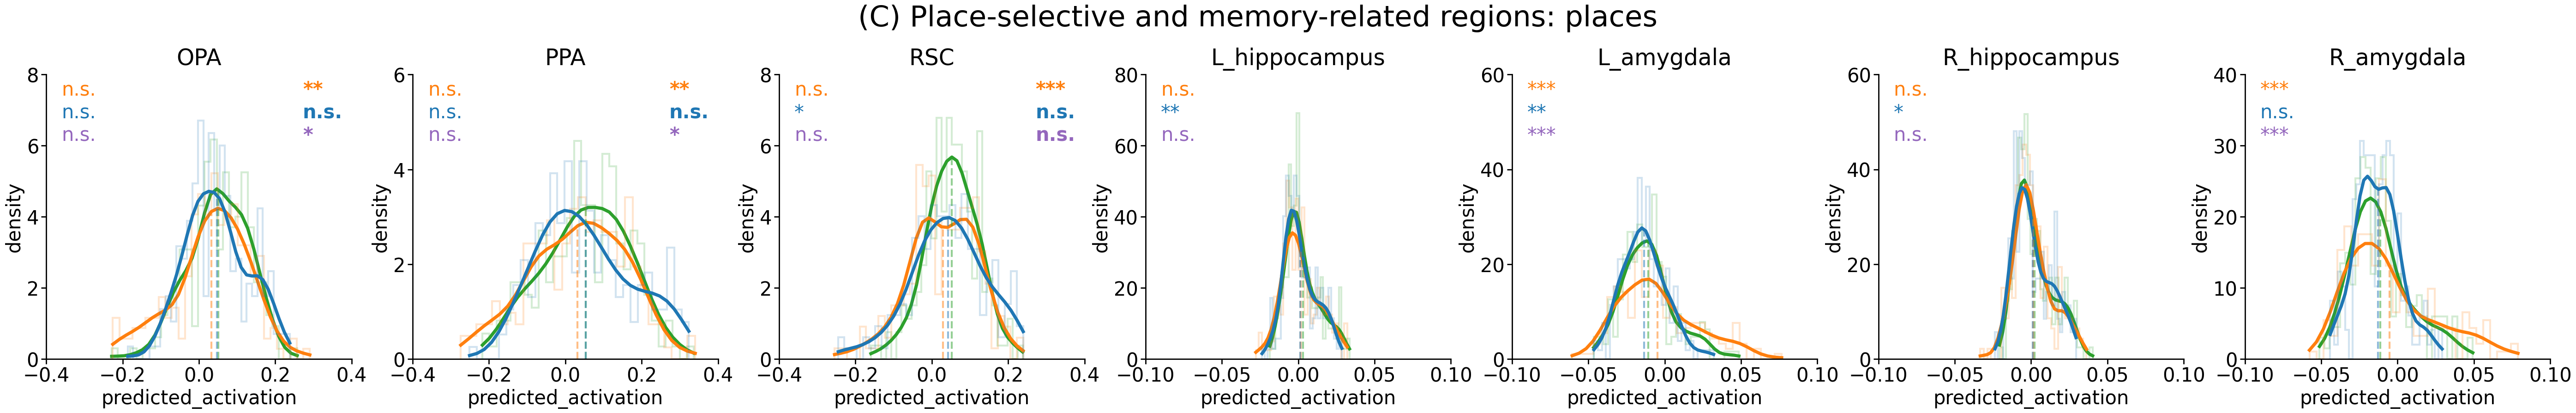

In [28]:
pm_ROIs = ['OPA', 'PPA', 'RSC', 'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala']
plt.figure(figsize=(70, 8))

for i, roi in enumerate(pm_ROIs):
    ax = plt.subplot2grid((1,7), (0, i))
    roi_idx = ROIs.index(roi)
    
    orig = pred[:,roi_idx]  
    high = pred_h[:,roi_idx]
    low = pred_l[:,roi_idx]

    _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
    _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    _, pvalue_hl = stats.ttest_rel(high, low, alternative='greater')
    
    if roi in ['OPA', 'PPA', 'RSC']:        
        _, pvalue_rh = stats.ttest_rel(orig, high, alternative='greater')
        _, pvalue_rl = stats.ttest_rel(orig, low, alternative='less')
        _, pvalue_rhl = stats.ttest_rel(high, low, alternative='less')
    
    # plot histogram
    no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    density_orig = stats.gaussian_kde(orig)
    line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    density_high = stats.gaussian_kde(high)
    line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    density_low = stats.gaussian_kde(low)
    line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # Mark the means
    mean_o = np.mean(orig)
    mean_h = np.mean(high)
    mean_l = np.mean(low)
    plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    if roi in ['OPA', 'PPA', 'RSC']:
        if pvalue_rh<0.001:
            prh = "***"
        elif pvalue_rh<0.01:
            prh = "**"
        elif pvalue_rh<0.05:
            prh = "*"
        else:
            prh = "n.s."
    
        if pvalue_rl<0.001:
            prl = "***"
        elif pvalue_rl<0.01:
            prl = "**"
        elif pvalue_rl<0.05:
            prl = "*"
        else:
            prl = "n.s."

        if pvalue_rhl<0.001:
            prhl = "***"
        elif pvalue_rhl<0.01:
            prhl = "**"
        elif pvalue_rhl<0.05:
            prhl = "*"
        else:
            prhl = "n.s."
        
        ax.text(0.84, 0.98, prh, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes, fontweight="semibold")
        ax.text(0.84, 0.9, prl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes, fontweight="semibold")
        ax.text(0.84, 0.82, prhl, fontsize=30, color="tab:purple", ha='left', va='top', transform=ax.transAxes, fontweight="semibold")
    
    if pvalue_h<0.001:
        ph = "***"
    elif pvalue_h<0.01:
        ph = "**"
    elif pvalue_h<0.05:
        ph = "*"
    else:
        ph = "n.s."

    if pvalue_l<0.001:
        pl = "***"
    elif pvalue_l<0.01:
        pl = "**"
    elif pvalue_l<0.05:
        pl = "*"
    else:
        pl = "n.s."

    if pvalue_hl<0.001:
        phl = "***"
    elif pvalue_hl<0.01:
        phl = "**"
    elif pvalue_hl<0.05:
        phl = "*"
    else:
        phl = "n.s."
    
    ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.82, phl, fontsize=30, color="tab:purple", ha='left', va='top', transform=ax.transAxes)

    plt.title(roi.replace('-', '_'), fontsize=35, pad=15)

    if roi in ['mTLbodies', 'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala']:
        plt.xticks([-0.1, -0.05, 0, 0.05, 0.1], fontsize=30)
    else:
        plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=30)
    plt.locator_params(axis='y', nbins=4)
    labels = [int(float(item.get_text())) for item in ax.get_yticklabels()]
    plt.yticks(labels, fontsize=30)
    
    ax.tick_params(width=2, length=8)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    ax.set_xlabel("predicted_activation", fontsize=30)
    ax.set_ylabel("density", fontsize=30)

# plt.figlegend(handles=[line_o, line_h, line_l], ncols=3, loc="lower center", fontsize=25, bbox_to_anchor=(0.5, -0.05))
plt.suptitle(f"(C) Place-selective and memory-related regions: {categories[idx]}", fontsize=45, y=1.07)
plt.savefig(base_dir+f"{categories[idx]}/placememory_ROIs_histplots.png", bbox_inches="tight")

## AlexNet

In [5]:
subjects = [2, 3, 4, 7, 8]
dict_shape = (len(ctrld_nids),len(subjects))
arr_shape = (len(ctrld_nids),len(ROIs))

pred_ROI_nsd = {k: np.zeros(dict_shape) for k in ROIs}
pred_ROI_h = {k: np.zeros(dict_shape) for k in ROIs}
pred_ROI_l = {k: np.zeros(dict_shape) for k in ROIs}

pred = np.zeros(arr_shape)
pred_h = np.zeros(arr_shape)
pred_l = np.zeros(arr_shape)

for i, subject in enumerate(subjects):
    sub_pred = np.load(ctrld_dir+f"including_memory/subj{subject:02d}/voxel_pred.npy")
    sub_pred_h = np.load(ctrld_dir+f"including_memory/subj{subject:02d}/voxel_pred_high.npy")
    sub_pred_l = np.load(ctrld_dir+f"including_memory/subj{subject:02d}/voxel_pred_low.npy")
    print("Before:", sub_pred.shape, sub_pred_h.shape, sub_pred_l.shape)

    for mroi in missing_ROIs[subject]:
        idx = default_ROIs.index(mroi)
        sub_pred = np.insert(sub_pred, idx, np.full((1000,), np.nan), axis=1)
        sub_pred_h = np.insert(sub_pred_h, idx, np.full((1000,), np.nan), axis=1)
        sub_pred_l = np.insert(sub_pred_l, idx, np.full((1000,), np.nan), axis=1)
    print("After:", sub_pred.shape, sub_pred_h.shape, sub_pred_l.shape)

    for j, roi in enumerate(ROIs):
        pred_ROI_nsd[roi][:,i] += sub_pred[ctrld_nids,j]
        pred_ROI_h[roi][:,i] += sub_pred_h[ctrld_nids,j]
        pred_ROI_l[roi][:,i] += sub_pred_l[ctrld_nids,j]

for i, k in enumerate(pred_ROI_nsd.keys()):
    pred_ROI_nsd[k] = pred_ROI_nsd[k][:,~np.all(np.isnan(pred_ROI_nsd[k]), axis=0)]
    pred[:,i] = pred_ROI_nsd[k].mean(axis=1)
    
    pred_ROI_h[k] = pred_ROI_h[k][:,~np.all(np.isnan(pred_ROI_h[k]), axis=0)]
    pred_h[:,i] = pred_ROI_h[k].mean(axis=1)
    
    pred_ROI_l[k] = pred_ROI_l[k][:,~np.all(np.isnan(pred_ROI_l[k]), axis=0)]
    pred_l[:,i] = pred_ROI_l[k].mean(axis=1)

print(pred.shape, pred_h.shape, pred_l.shape)

Before: (1000, 20) (1000, 20) (1000, 20)
After: (1000, 23) (1000, 23) (1000, 23)
Before: (1000, 21) (1000, 21) (1000, 21)
After: (1000, 23) (1000, 23) (1000, 23)
Before: (1000, 22) (1000, 22) (1000, 22)
After: (1000, 23) (1000, 23) (1000, 23)
Before: (1000, 21) (1000, 21) (1000, 21)
After: (1000, 23) (1000, 23) (1000, 23)
Before: (1000, 23) (1000, 23) (1000, 23)
After: (1000, 23) (1000, 23) (1000, 23)
(152, 23) (152, 23) (152, 23)


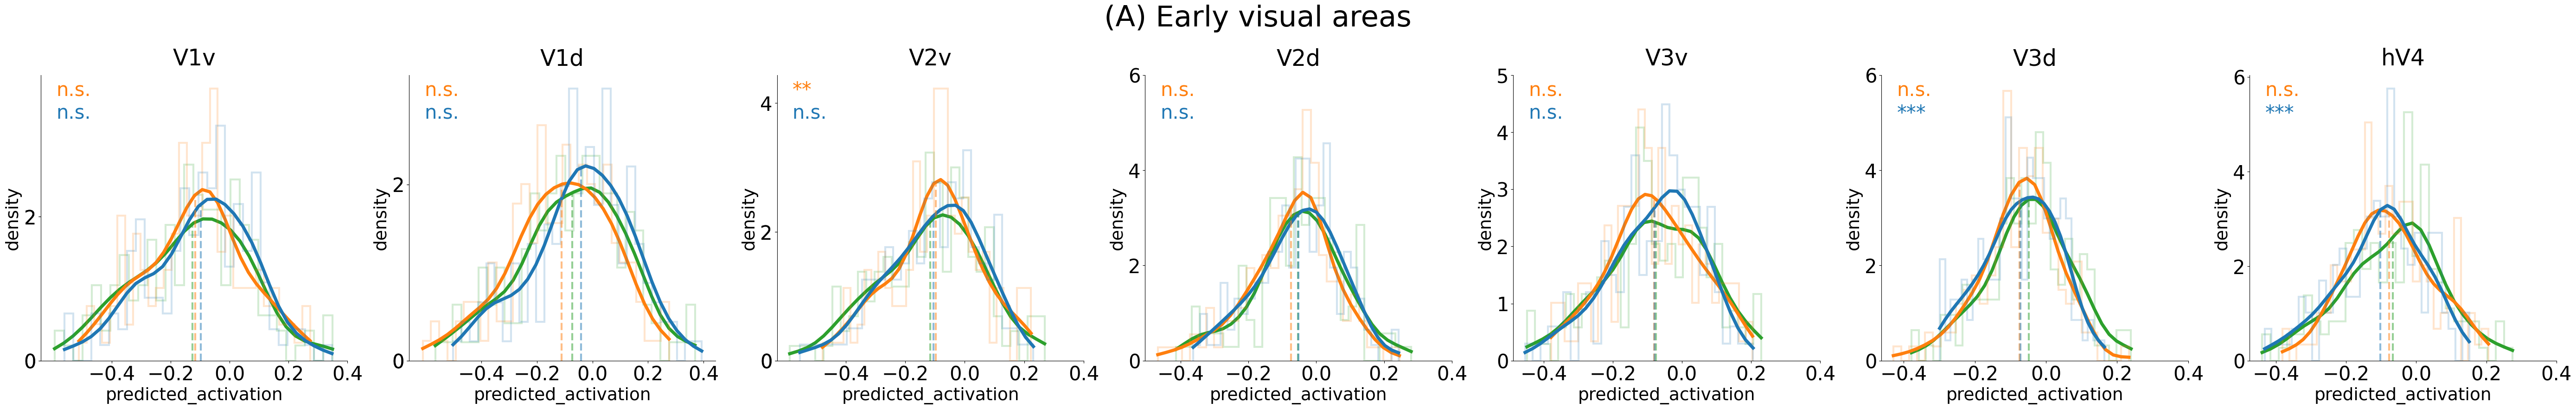

In [102]:
ev_ROIs = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
plt.figure(figsize=(70, 8))

for i, roi in enumerate(ev_ROIs):
    ax = plt.subplot2grid((1,7), (0, i))
    roi_idx = ROIs.index(roi)
    
    orig = pred[:,roi_idx]  
    high = pred_h[:,roi_idx]
    low = pred_l[:,roi_idx]
    
    _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
    _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    
    # plot histogram
    no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    density_orig = stats.gaussian_kde(orig)
    line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    density_high = stats.gaussian_kde(high)
    line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    density_low = stats.gaussian_kde(low)
    line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # Mark the means
    mean_o = np.mean(orig)
    mean_h = np.mean(high)
    mean_l = np.mean(low)
    plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    if pvalue_h<0.001:
        ph = "***"
    elif pvalue_h<0.01:
        ph = "**"
    elif pvalue_h<0.05:
        ph = "*"
    else:
        ph = "n.s."

    if pvalue_l<0.001:
        pl = "***"
    elif pvalue_l<0.01:
        pl = "**"
    elif pvalue_l<0.05:
        pl = "*"
    else:
        pl = "n.s."
    
    plt.title(roi, fontsize=35, pad=15)
    
    ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
    
    plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=30)
    labels = [int(float(item.get_text())) for item in ax.get_yticklabels()]
    if len(labels) >= 8:
        labels = labels[:-1]
    if len(labels) > 6:
        labels = [e for e in labels if e % 2 == 0]
    plt.yticks(labels, fontsize=30)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("predicted_activation", fontsize=27)
    ax.set_ylabel("density", fontsize=27)

# plt.figlegend(handles=[line_o, line_h, line_l], ncols=3, loc="upper right", fontsize=25, bbox_to_anchor=(0.91, 1.12))
plt.suptitle("(A) Early visual areas", fontsize=45, y=1.07)
# plt.show()
plt.savefig("data/memorability_controlled_test_70p/including_memory/earlyvisual_ROIs_histplots.png", bbox_inches="tight")

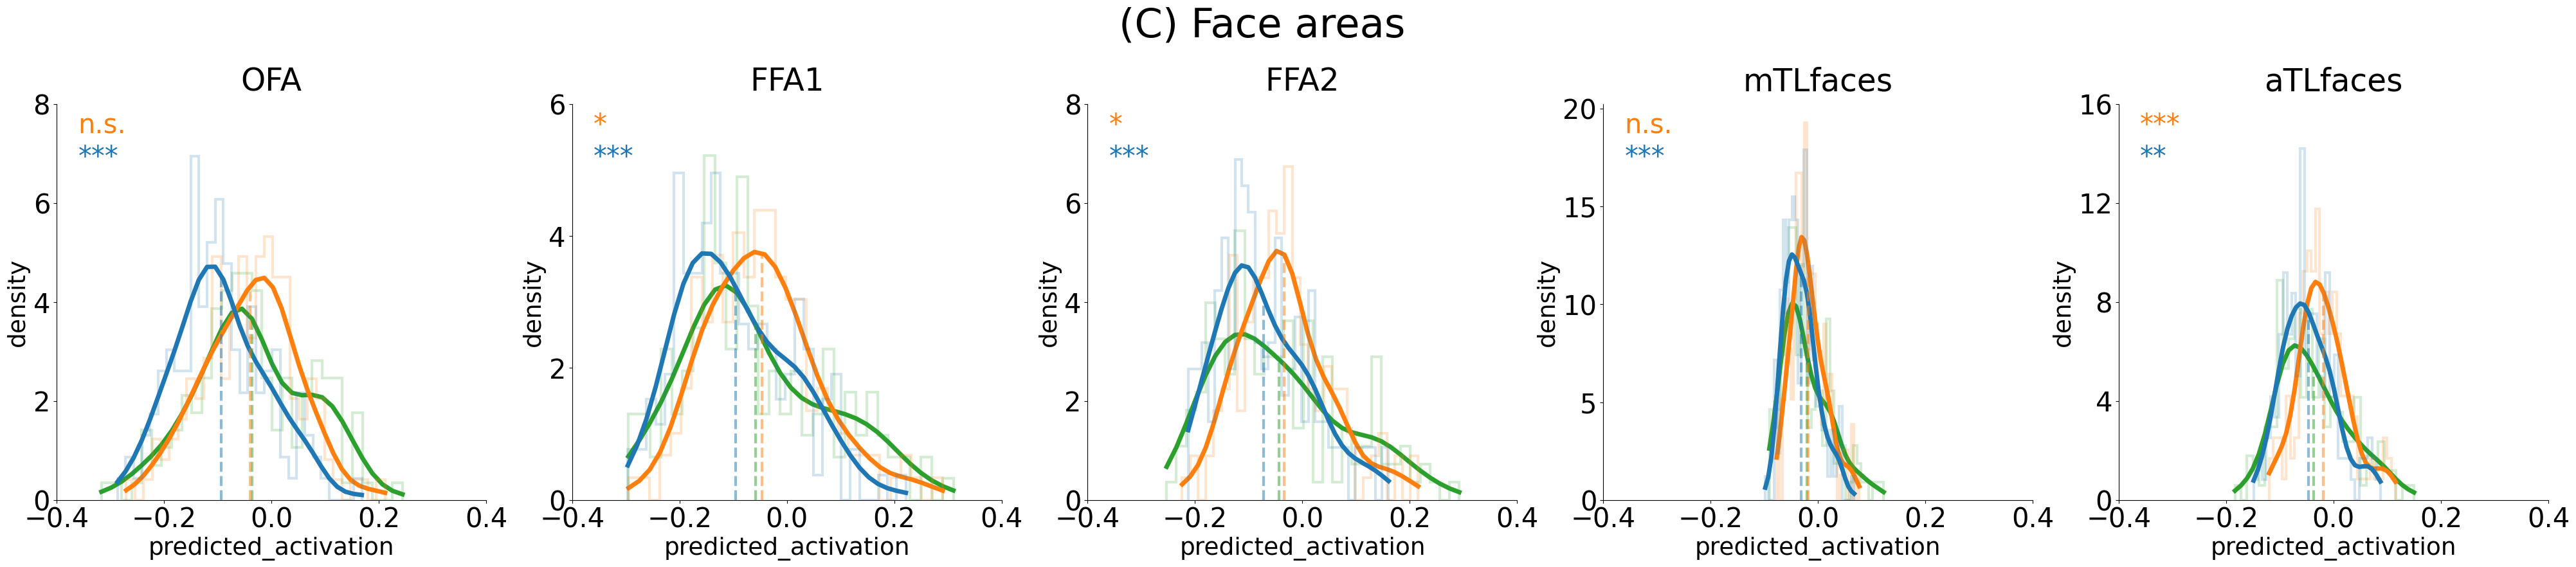

In [135]:
# Face Area
face_ROIs = ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces']
plt.figure(figsize=(50, 8))

for i, roi in enumerate(face_ROIs):
    ax = plt.subplot2grid((1,5), (0, i))
    roi_idx = ROIs.index(roi)
    
    orig = pred[:,roi_idx]  
    high = pred_h[:,roi_idx]
    low = pred_l[:,roi_idx]
    
    _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
    _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    
    # plot histogram
    no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    density_orig = stats.gaussian_kde(orig)
    line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    density_high = stats.gaussian_kde(high)
    line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    density_low = stats.gaussian_kde(low)
    line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # Mark the means
    mean_o = np.mean(orig)
    mean_h = np.mean(high)
    mean_l = np.mean(low)
    plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    if pvalue_h<0.001:
        ph = "***"
    elif pvalue_h<0.01:
        ph = "**"
    elif pvalue_h<0.05:
        ph = "*"
    else:
        ph = "n.s."

    if pvalue_l<0.001:
        pl = "***"
    elif pvalue_l<0.01:
        pl = "**"
    elif pvalue_l<0.05:
        pl = "*"
    else:
        pl = "n.s."
    
    plt.title(roi, fontsize=35, pad=15)
    
    ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
    
    plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=30)
    labels = [int(float(item.get_text())) for item in ax.get_yticklabels()]
    if labels[-1] > 20:
        labels = [e for e in labels if e % 5 == 0]
    else:
        if len(labels) > 9:
            labels = labels[:-1]
        if len(labels) > 8:
            if labels[-1] > 14:
                labels = [e for e in labels if e % 4 == 0]
            else:
                labels = [e for e in labels if e % 2 == 0]
        elif len(labels) > 6:
            labels = [e for e in labels if e % 2 == 0]
    plt.yticks(labels, fontsize=30)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("predicted_activation", fontsize=27)
    ax.set_ylabel("density", fontsize=27)

# plt.figlegend(handles=[line_o, line_h, line_l], ncols=3, loc="lower center", fontsize=25, bbox_to_anchor=(0.5, -0.05))
plt.suptitle("(C) Face areas", fontsize=45, y=1.07)
plt.savefig("data/memorability_controlled_test_70p/including_memory/face_ROIs_histplots.png", bbox_inches="tight")
plt.show()

In [63]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

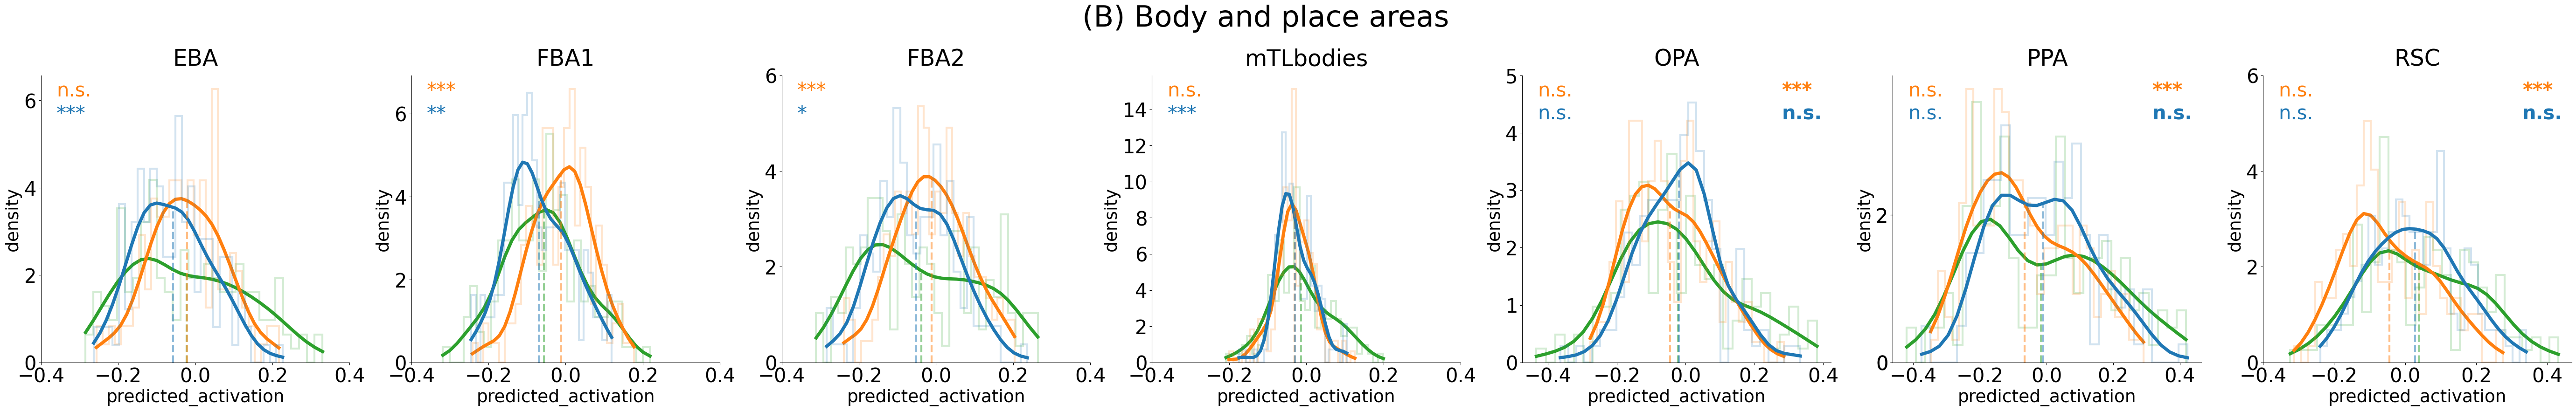

In [136]:
# Body & Place Area
bp_ROIs = ['EBA', 'FBA1', 'FBA2', 'mTLbodies', 'OPA', 'PPA', 'RSC']
plt.figure(figsize=(70, 8))

for i, roi in enumerate(bp_ROIs):
    ax = plt.subplot2grid((1,7), (0, i))
    roi_idx = ROIs.index(roi)
    
    orig = pred[:,roi_idx]  
    high = pred_h[:,roi_idx]
    low = pred_l[:,roi_idx]

    if roi in ['OPA', 'PPA', 'RSC']:
        _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
        _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
        
        _, pvalue_rh = stats.ttest_rel(orig, high, alternative='greater')
        _, pvalue_rl = stats.ttest_rel(orig, low, alternative='less')
    else:
        _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
        _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    
    # plot histogram
    no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    density_orig = stats.gaussian_kde(orig)
    line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    density_high = stats.gaussian_kde(high)
    line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    density_low = stats.gaussian_kde(low)
    line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # Mark the means
    mean_o = np.mean(orig)
    mean_h = np.mean(high)
    mean_l = np.mean(low)
    plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    

    if roi in ['OPA', 'PPA', 'RSC']:
        if pvalue_rh<0.001:
            prh = "***"
        elif pvalue_rh<0.01:
            prh = "**"
        elif pvalue_rh<0.05:
            prh = "*"
        else:
            prh = "n.s."
    
        if pvalue_rl<0.001:
            prl = "***"
        elif pvalue_rl<0.01:
            prl = "**"
        elif pvalue_rl<0.05:
            prl = "*"
        else:
            prl = "n.s."
        
        ax.text(0.84, 0.98, prh, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes, fontweight="semibold")
        ax.text(0.84, 0.9, prl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes, fontweight="semibold")
    
    if pvalue_h<0.001:
        ph = "***"
    elif pvalue_h<0.01:
        ph = "**"
    elif pvalue_h<0.05:
        ph = "*"
    else:
        ph = "n.s."

    if pvalue_l<0.001:
        pl = "***"
    elif pvalue_l<0.01:
        pl = "**"
    elif pvalue_l<0.05:
        pl = "*"
    else:
        pl = "n.s."
    
    ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
        

    plt.title(roi, fontsize=35, pad=15)
    
    plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=30)
    labels = [int(float(item.get_text())) for item in ax.get_yticklabels()]
    if len(labels) >= 8:
        labels = labels[:-1]
    if len(labels) > 6:
        labels = [e for e in labels if e % 2 == 0]
    plt.yticks(labels, fontsize=30)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("predicted_activation", fontsize=27)
    ax.set_ylabel("density", fontsize=27)

# plt.figlegend(handles=[line_o, line_h, line_l], ncols=3, loc="lower center", fontsize=25, bbox_to_anchor=(0.5, -0.05))
plt.suptitle("(B) Body and place areas", fontsize=45, y=1.07)
plt.savefig("data/memorability_controlled_test_70p/including_memory/bodyplace_ROIs_histplots.png", bbox_inches="tight")
plt.show()

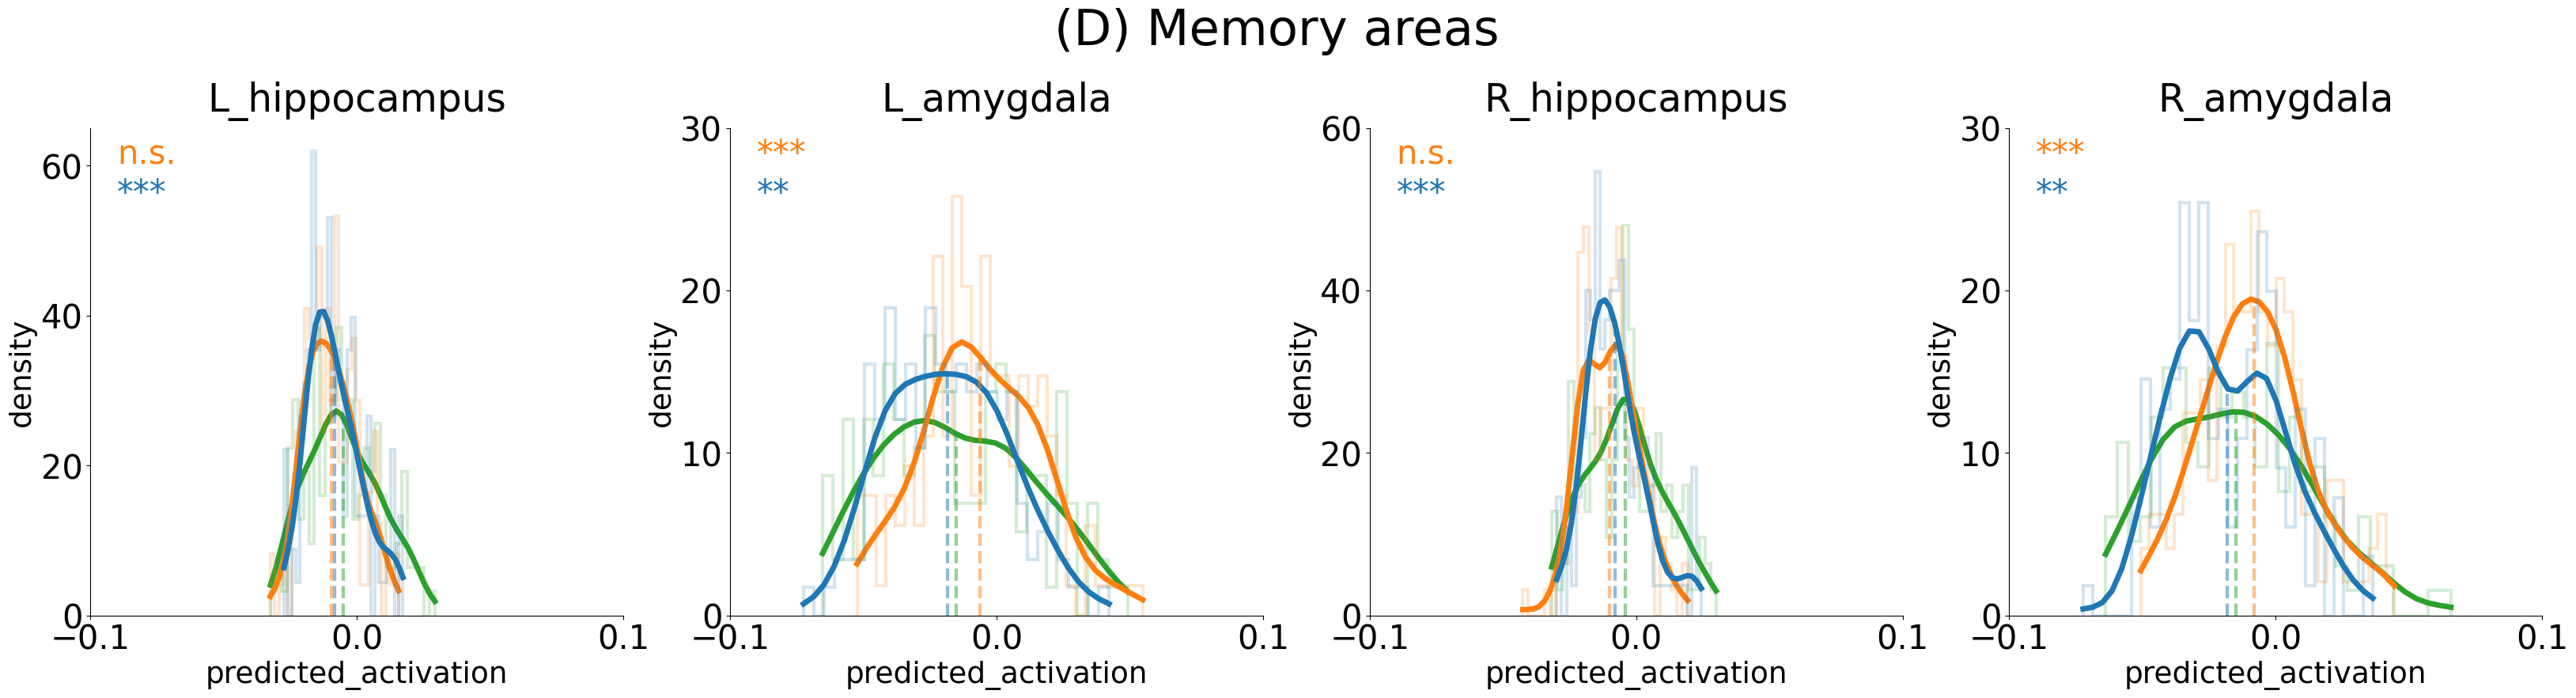

In [105]:
mem_ROIs = ['L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala']
plt.figure(figsize=(40, 8))

for i, roi in enumerate(mem_ROIs):
    ax = plt.subplot2grid((1,4), (0, i))
    roi_idx = ROIs.index(roi)
    
    orig = pred[:,roi_idx]  
    high = pred_h[:,roi_idx]
    low = pred_l[:,roi_idx]
    
    _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
    _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    
    # plot histogram
    no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    density_orig = stats.gaussian_kde(orig)
    line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    density_high = stats.gaussian_kde(high)
    line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    density_low = stats.gaussian_kde(low)
    line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # Mark the means
    mean_o = np.mean(orig)
    mean_h = np.mean(high)
    mean_l = np.mean(low)
    plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    if pvalue_h<0.001:
        ph = "***"
    elif pvalue_h<0.01:
        ph = "**"
    elif pvalue_h<0.05:
        ph = "*"
    else:
        ph = "n.s."

    if pvalue_l<0.001:
        pl = "***"
    elif pvalue_l<0.01:
        pl = "**"
    elif pvalue_l<0.05:
        pl = "*"
    else:
        pl = "n.s."
    
    plt.title(roi.replace('-', '_'), fontsize=35, pad=15)
    
    ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
    
    plt.xticks([-0.1, 0, 0.1], fontsize=30)
    labels = [int(float(item.get_text())) for item in ax.get_yticklabels()]
    labels = [e for e in labels if e % 10 == 0]
    if len(labels) > 6:
        labels = [e for e in labels if e % 20 == 0]
    plt.yticks(labels, fontsize=30)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("predicted_activation", fontsize=27)
    ax.set_ylabel("density", fontsize=27)

# plt.figlegend(handles=[line_o, line_h, line_l], ncols=3, loc="lower center", fontsize=25, bbox_to_anchor=(0.5, -0.05))
plt.suptitle("(D) Memory areas", fontsize=45, y=1.07)
plt.savefig("data/memorability_controlled_test_70p/including_memory/memory_ROIs_histplots.png", bbox_inches="tight")
plt.show()

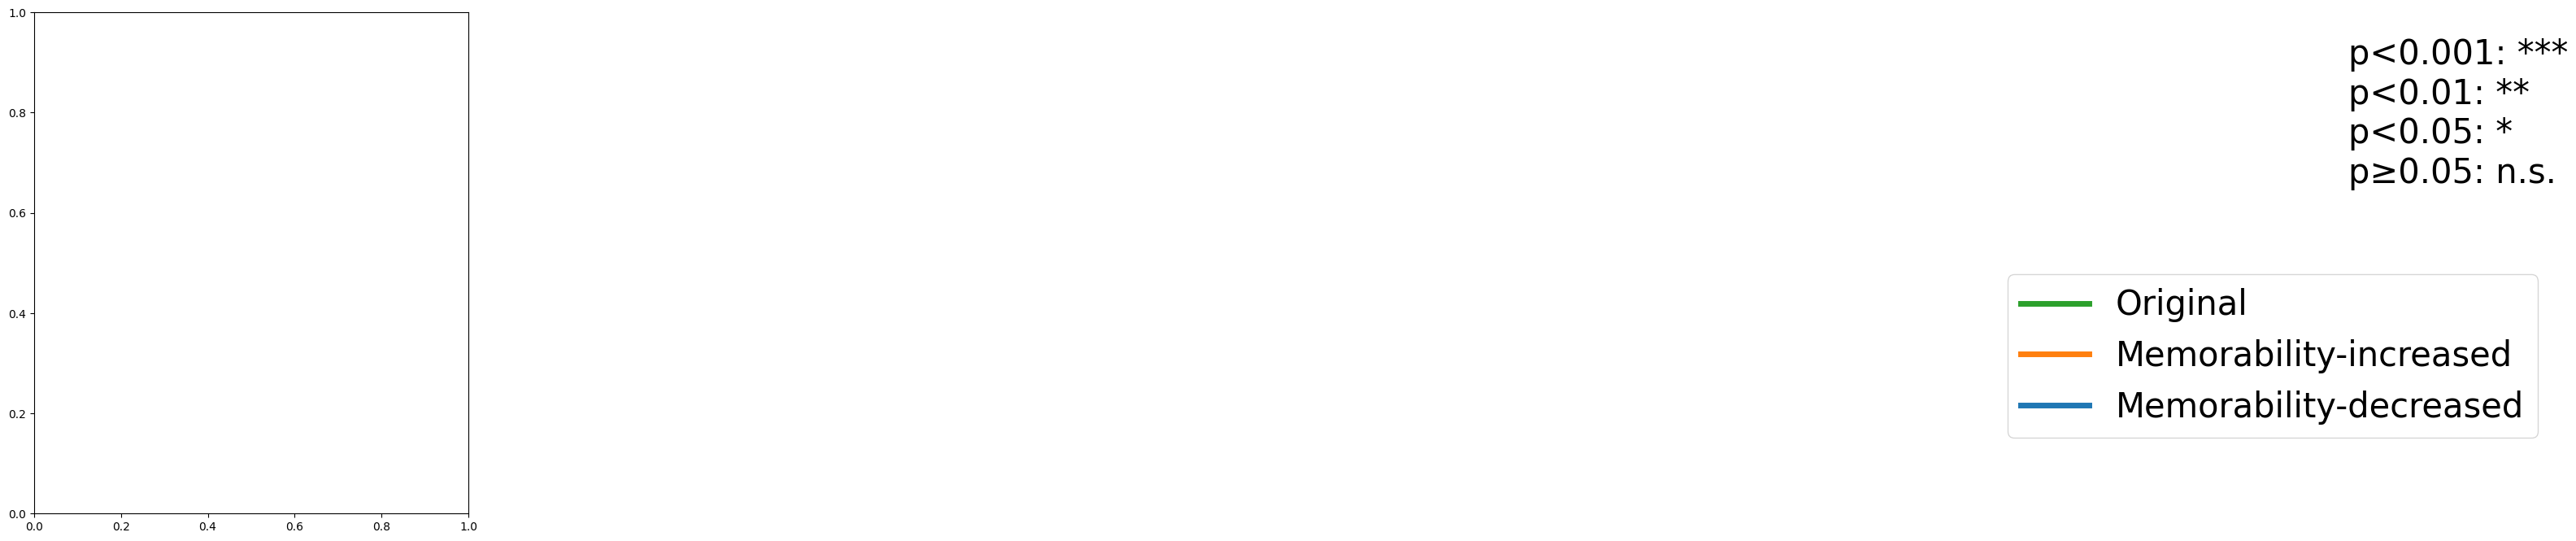

In [134]:
mem_ROIs = ['L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala', ""]
plt.figure(figsize=(40, 8))

for i, roi in enumerate(mem_ROIs):
    ax = plt.subplot2grid((1,5), (0, i))
    break
    # if i == 4:
    #     break
    # roi_idx = ROIs.index(roi)
    
    # orig = pred[:,roi_idx]  
    # high = pred_h[:,roi_idx]
    # low = pred_l[:,roi_idx]
    
    # _, pvalue_h = stats.ttest_rel(orig, high, alternative='less')
    # _, pvalue_l = stats.ttest_rel(orig, low, alternative='greater')
    
    # # plot histogram
    # no, xo, _ = plt.hist(orig, alpha=0.2, color="tab:green", histtype='step', density=True, bins=30, linewidth=3)
    # density_orig = stats.gaussian_kde(orig)
    # line_o, = plt.plot(xo, density_orig(xo), color="tab:green", linewidth=5, label='Original')
    
    # nh, xh, _ =  plt.hist(high, alpha=0.2, color="tab:orange", histtype='step', density=True, bins=30, linewidth=3)
    # density_high = stats.gaussian_kde(high)
    # line_h, = plt.plot(xh, density_high(xh), color="tab:orange", linewidth=5, label='Memorability-increased')
    
    # nl, xl, _ =  plt.hist(low, alpha=0.2, color="tab:blue", histtype='step', density=True, bins=30, linewidth=3)
    # density_low = stats.gaussian_kde(low)
    # line_l, = plt.plot(xl, density_low(xl), color="tab:blue", linewidth=5, label='Memorability-decreased')

    # # Mark the means
    # mean_o = np.mean(orig)
    # mean_h = np.mean(high)
    # mean_l = np.mean(low)
    # plt.vlines([mean_o, mean_h, mean_l], ymin=0, ymax=[density_orig(mean_o), density_high(mean_h), density_low(mean_l)], alpha=0.5, linestyle='dashed', colors=["tab:green", "tab:orange", "tab:blue"], label='Means', linewidth=3)

    # if pvalue_h<0.001:
    #     ph = "***"
    # elif pvalue_h<0.01:
    #     ph = "**"
    # elif pvalue_h<0.05:
    #     ph = "*"
    # else:
    #     ph = "n.s."

    # if pvalue_l<0.001:
    #     pl = "***"
    # elif pvalue_l<0.01:
    #     pl = "**"
    # elif pvalue_l<0.05:
    #     pl = "*"
    # else:
    #     pl = "n.s."
    
    # plt.title(roi.replace('-', '_'), fontsize=35, pad=15)
    
    # ax.text(0.05, 0.98, ph, fontsize=30, color="tab:orange", ha='left', va='top', transform=ax.transAxes)
    # ax.text(0.05, 0.9, pl, fontsize=30, color="tab:blue", ha='left', va='top', transform=ax.transAxes)
    
    # plt.xticks([-0.1, 0, 0.1], fontsize=30)
    # labels = [int(float(item.get_text())) for item in ax.get_yticklabels()]
    # labels = [e for e in labels if e % 10 == 0]
    # if len(labels) > 6:
    #     labels = [e for e in labels if e % 20 == 0]
    # plt.yticks(labels, fontsize=30)
    
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # ax.set_xlabel("predicted_activation", fontsize=27)
    # ax.set_ylabel("density", fontsize=27)

plt.figlegend(handles=[line_o, line_h, line_l], loc="lower right", fontsize=30, bbox_to_anchor=(0.9, 0.2))
textstr = "p<0.001: ***\np<0.01: **\np<0.05: *\np≥0.05: n.s.\nBold"
# props = dict(boxstyle='round', facecolor="white", alpha=0.2)
plt.text(5.325, 0.95, textstr, fontsize=30, va='top')
# plt.suptitle("(D) Memory areas", fontsize=45, y=1.07)
# plt.savefig("data/memorability_controlled_test_70p/including_memory/memory_ROIs_histplots.png", bbox_inches="tight")
plt.show()

### Big Grid

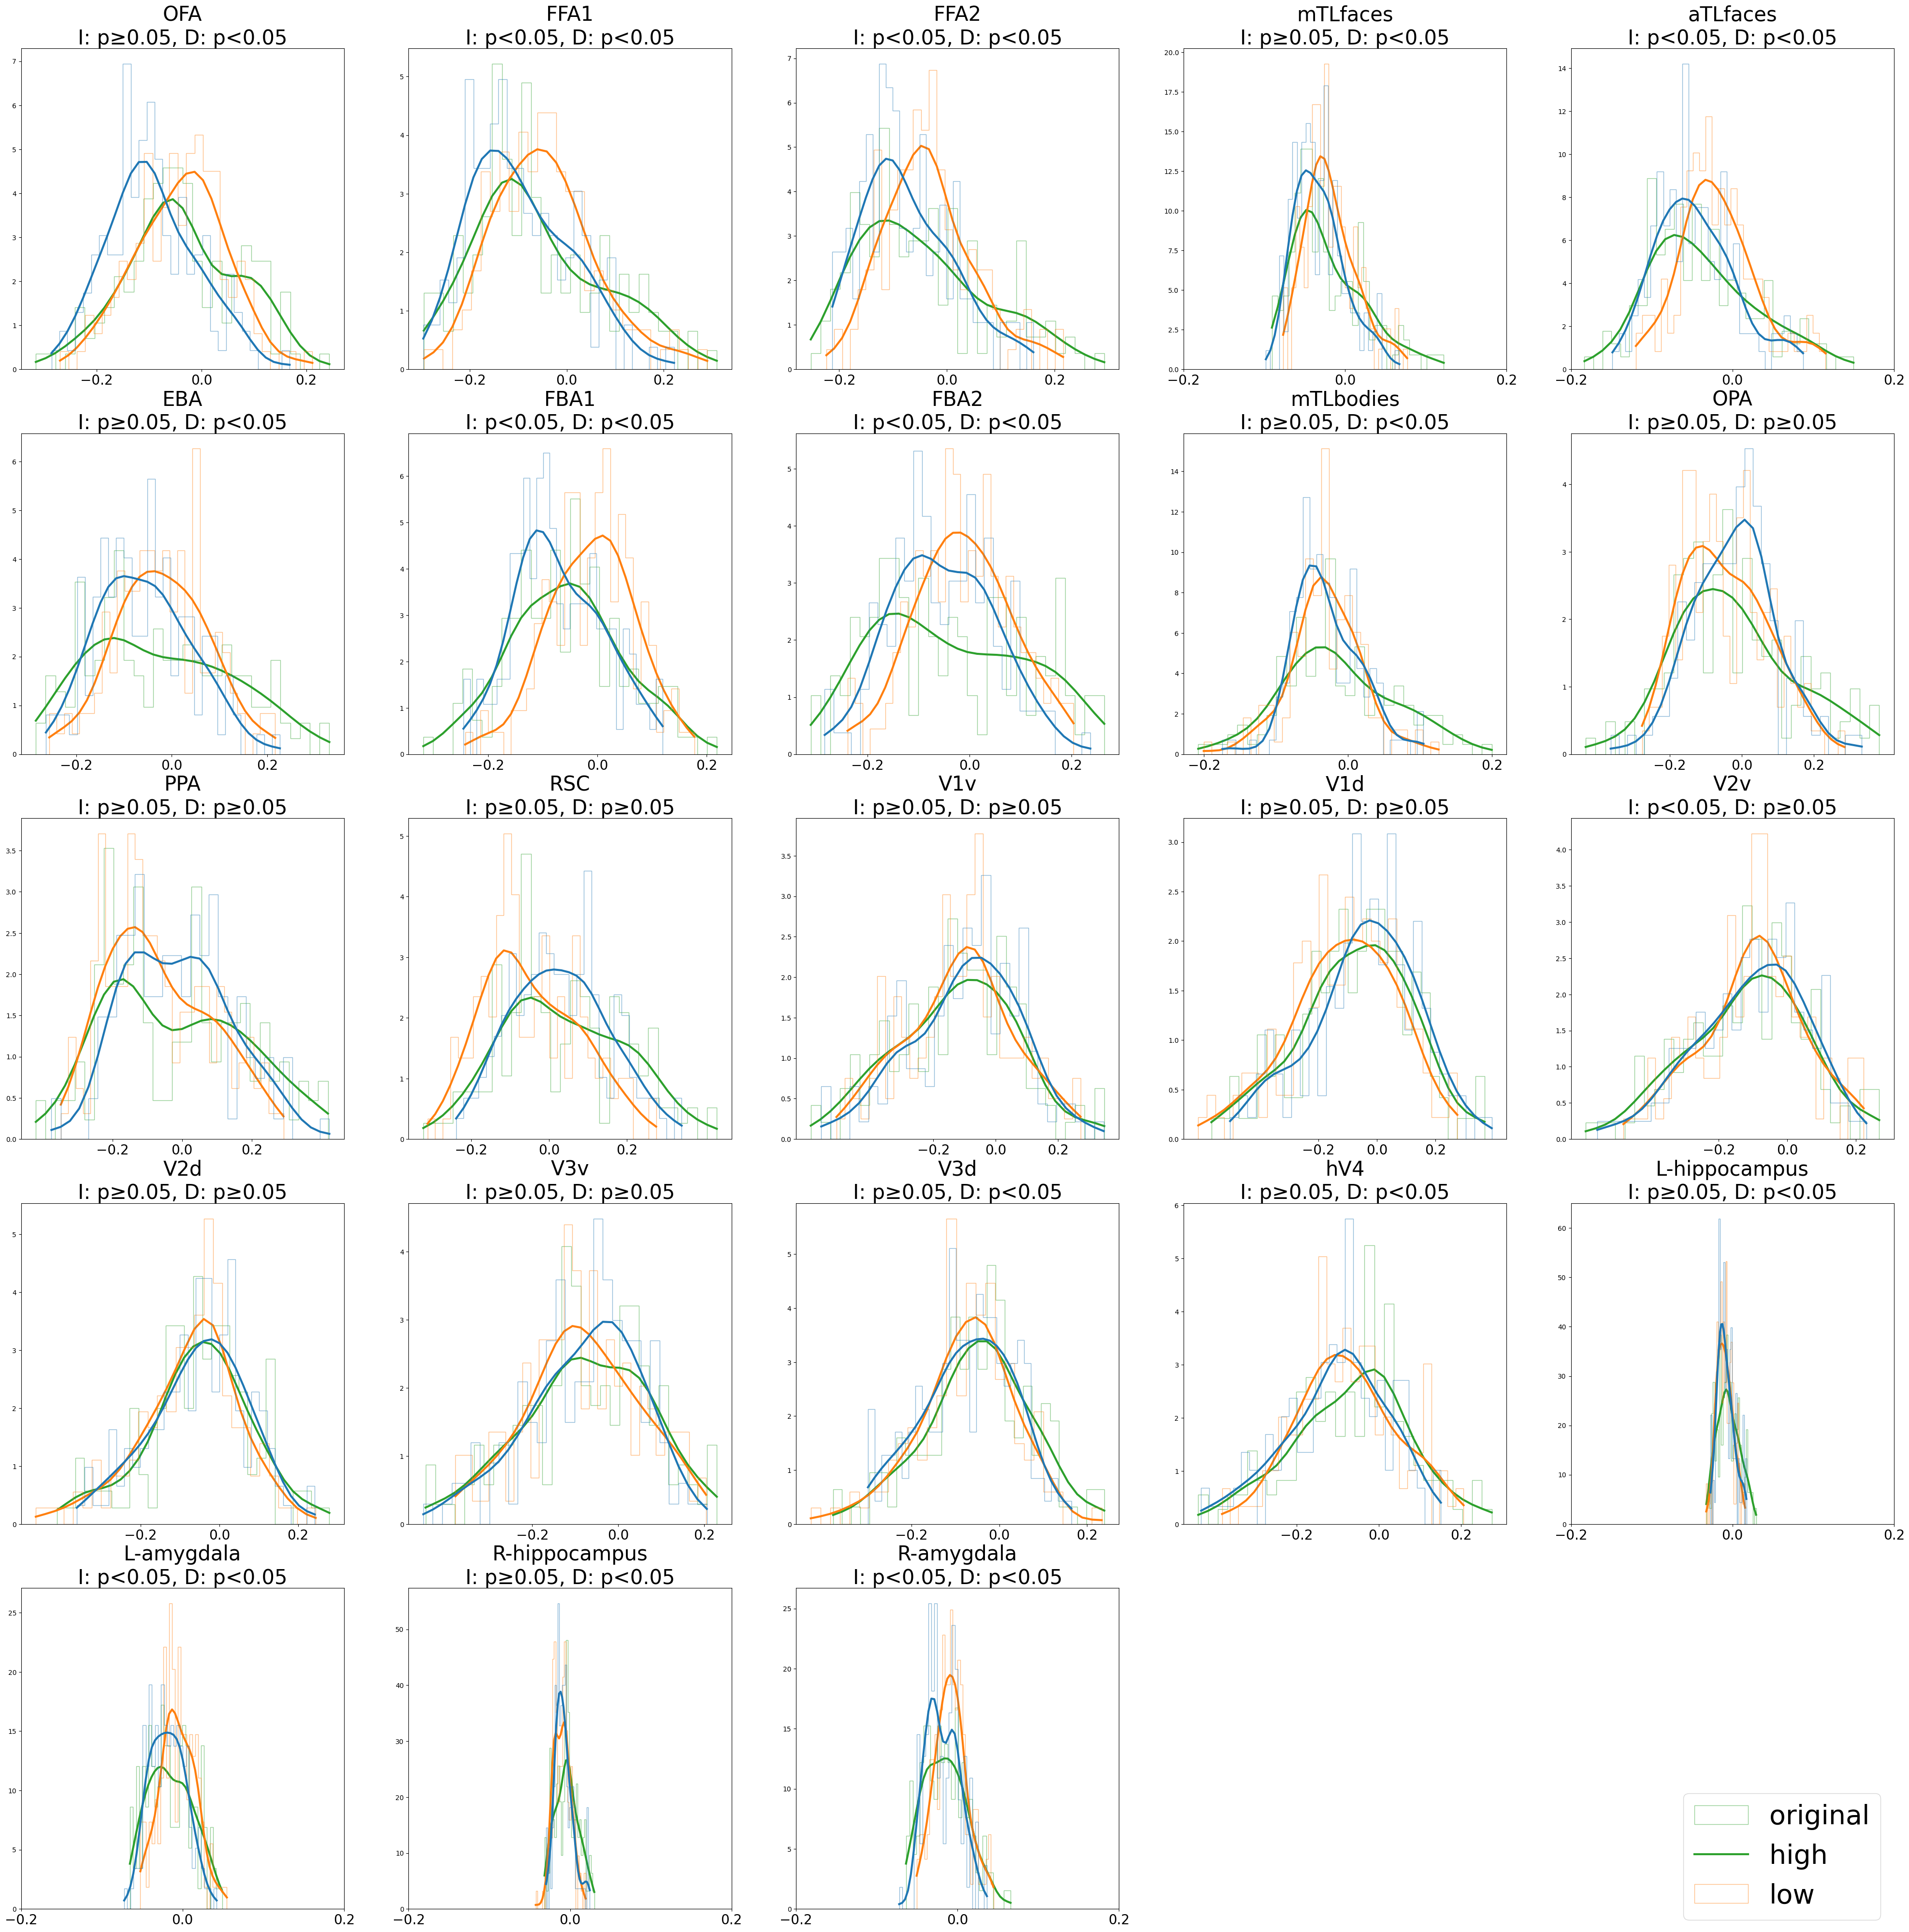

In [20]:
plt.figure(figsize=(50,50))

roi_id = 0
pvalue_h = np.zeros((23,))
pvalue_l = np.zeros((23,))

for i in range(5):
    for j in range(5):
        if roi_id == 23:
            break
        ax0 = plt.subplot2grid((5,5), (i,j))
        # predicted activation for high and low memorable images
        orig = pred[:,roi_id]  
        high = pred_h[:,roi_id]
        low = pred_l[:,roi_id]

        # ttest
        (_, pvalue_l[roi_id]) = stats.ttest_rel(orig, low, alternative='greater')
        (_, pvalue_h[roi_id]) = stats.ttest_rel(orig, high, alternative='less')

        # plot histogram
        no, xo, _ = plt.hist(orig, alpha=0.5, color="tab:green", histtype='step', density=True, label='original', bins=30)
        density_orig = stats.gaussian_kde(orig)
        plt.plot(xo, density_orig(xo), color="tab:green", linewidth=3)
        
        nh, xh, _ =  plt.hist(high, alpha=0.5, color="tab:orange", histtype='step', density=True, label='high', bins=30)
        density_high = stats.gaussian_kde(high)
        plt.plot(xh, density_high(xh), color="tab:orange", linewidth=3)
        
        nl, xl, _ =  plt.hist(low, alpha=0.5, color="tab:blue", histtype='step', density=True, label='low', bins=30)
        density_low = stats.gaussian_kde(low)
        plt.plot(xl, density_low(xl), color="tab:blue", linewidth=3)
        

        # plt.axvline(pred[:,roi_id].mean(), color="tab:green", label='mean', alpha=0.5, linewidth=2)
        # plt.axvline(pred_h[:,roi_id].mean(), color="tab:orange", label='mean', alpha=0.5, linewidth=2)
        # plt.axvline(pred_l[:,roi_id].mean(), color="tab:blue", label='mean', alpha=0.5, linewidth=2)

        if pvalue_h[roi_id]<0.05:
            ph = "p<0.05"
        else:
            ph = "p≥0.05"

        if pvalue_l[roi_id]<0.05:
            pl = "p<0.05"
        else:
            pl = "p≥0.05"

        plt.title(f"{ROIs[roi_id]}\nI: {ph}, D: {pl}", fontsize=30)
        
        plt.xticks([-0.2, 0, 0.2], fontsize=20)
        # plt.yticks([0, 25, 50], fontsize=20)
        roi_id += 1

plt.figlegend(['original', 'high', 'low'], loc="lower right", fontsize=40, bbox_to_anchor=(0.9, 0.1))
plt.show()

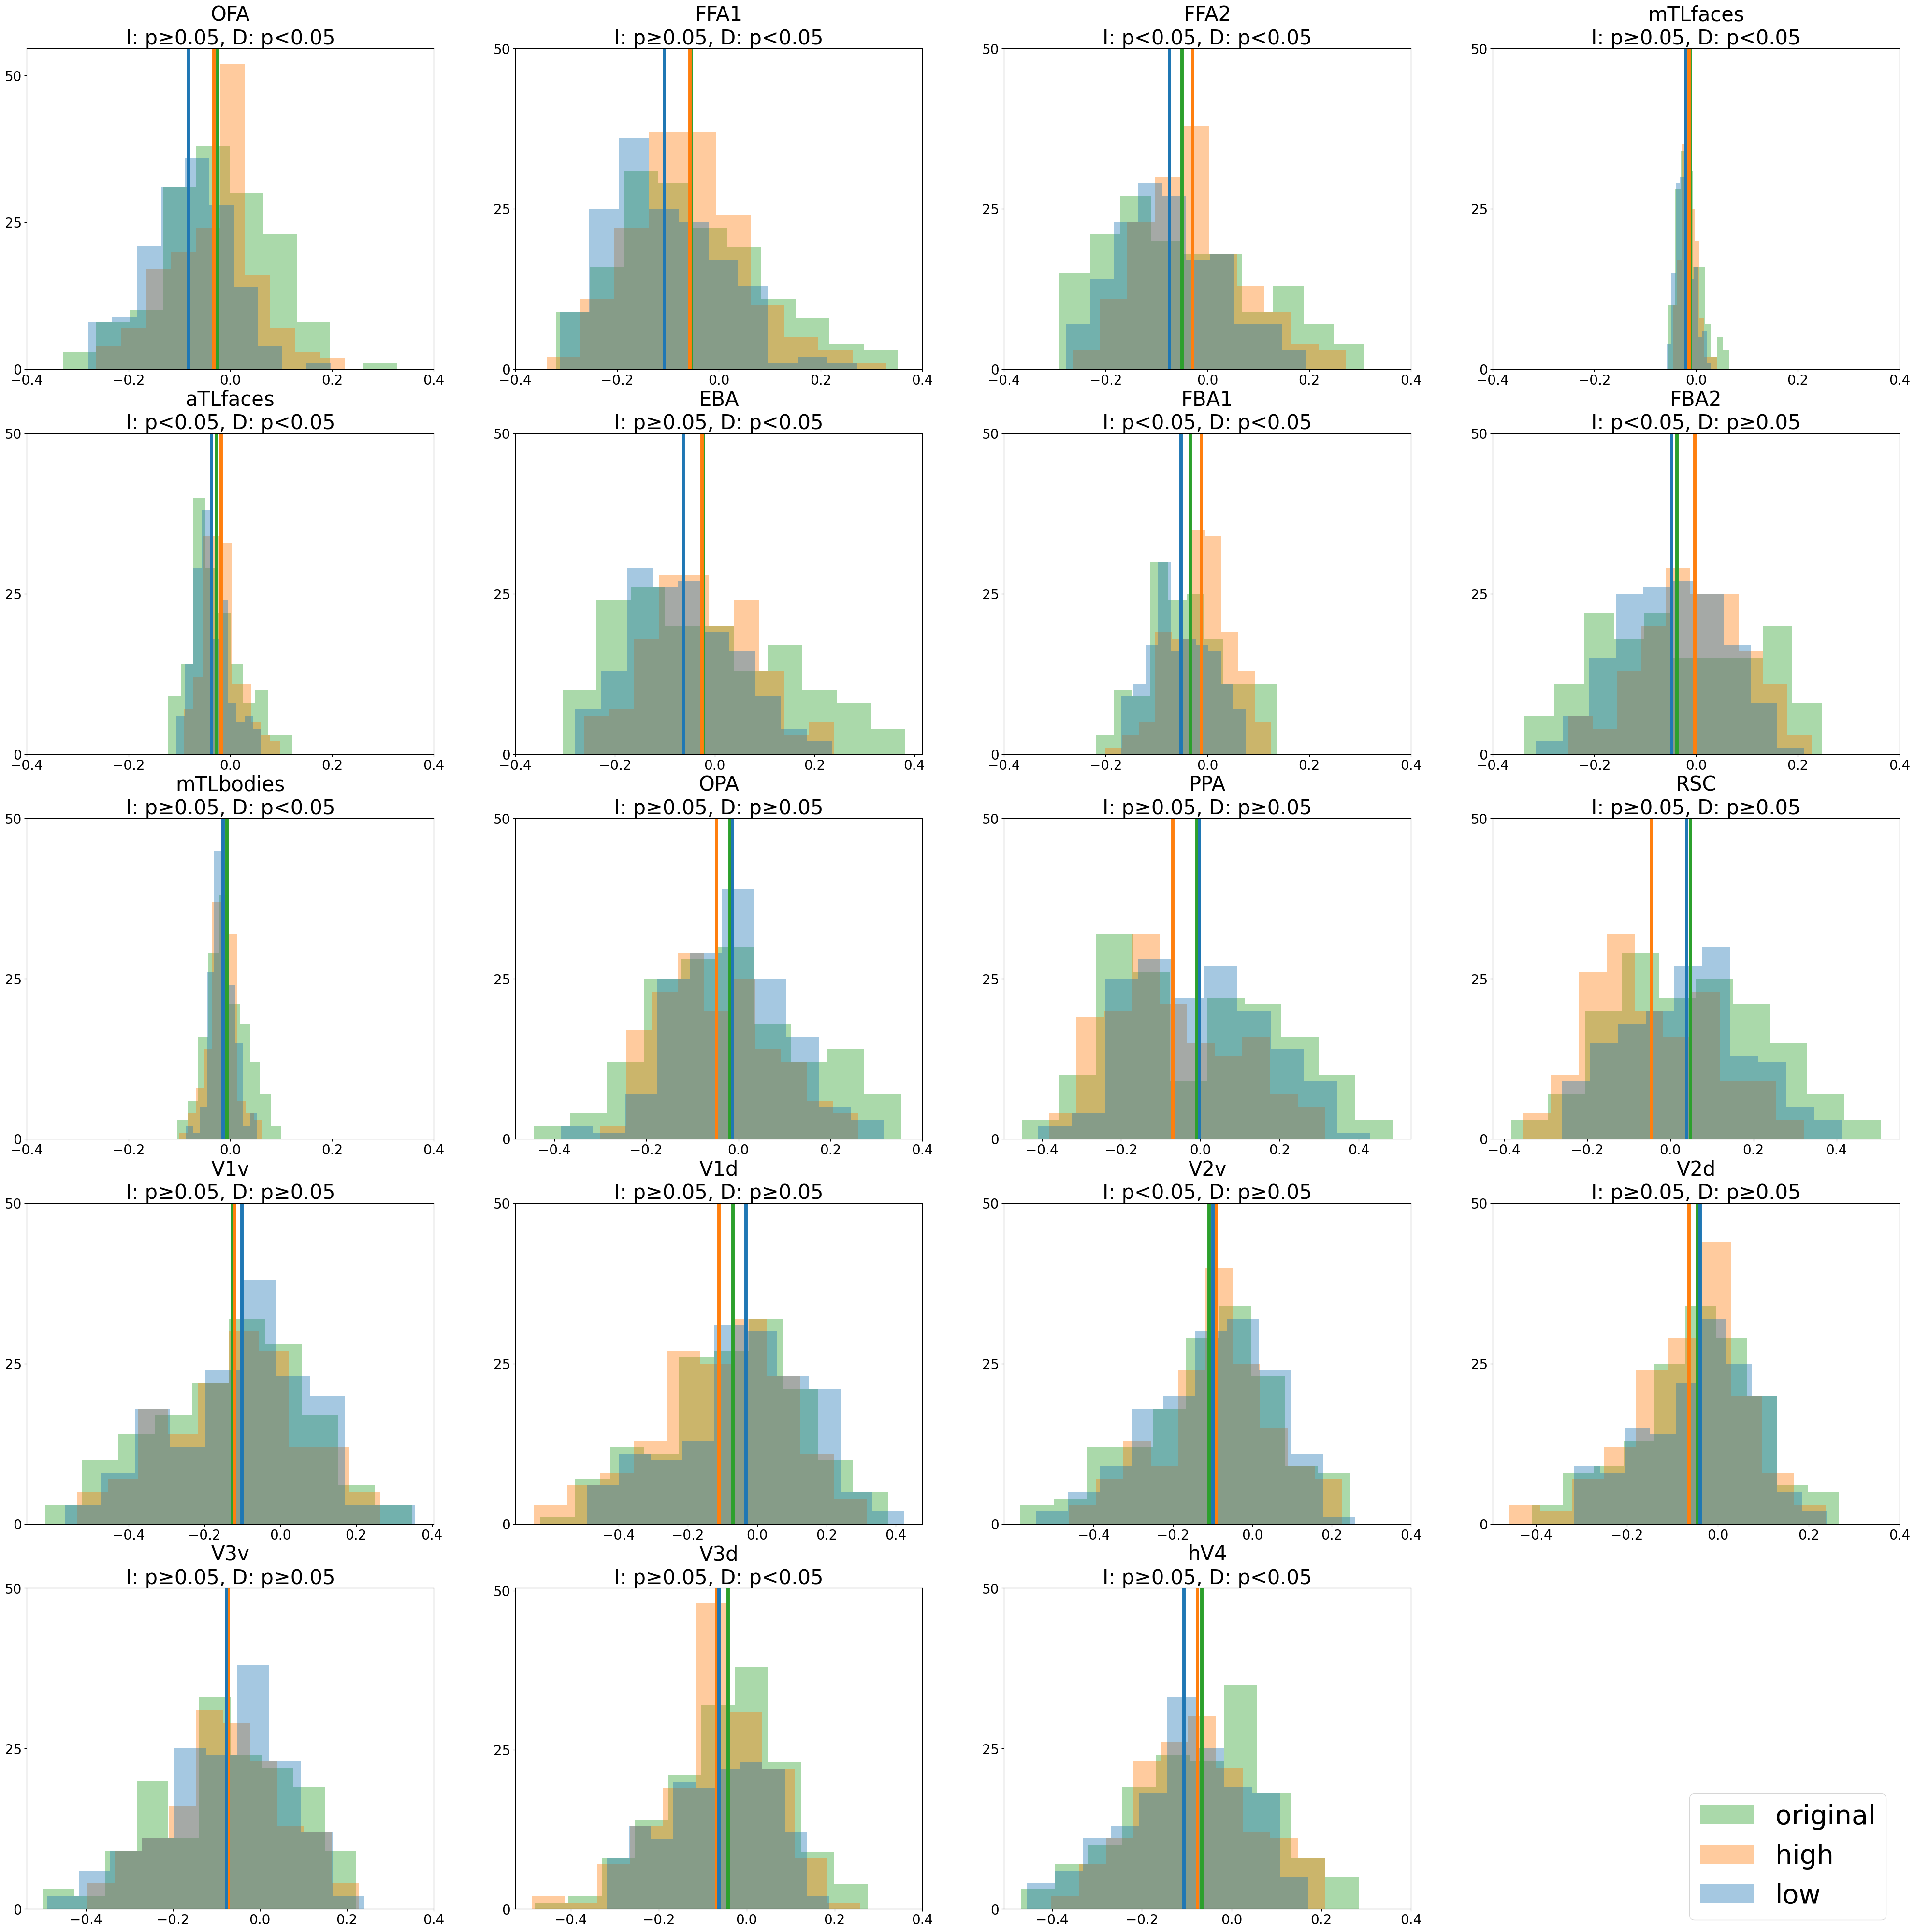

In [41]:
# visual only
plt.figure(figsize=(50,50))

roi_id = 0
pvalue_h = np.zeros((19,))
pvalue_l = np.zeros((19,))

for i in range(5):
    for j in range(4):
        if roi_id == 19:
            break
        ax0 = plt.subplot2grid((5,4), (i,j))
        # predicted activation for high and low memorable images
        orig = pred[:,roi_id]
        orig = orig[~np.isnan(orig)]
        
        high = pred_h[:,roi_id]
        high = high[~np.isnan(high)]
        
        low = pred_l[:,roi_id]
        low = low[~np.isnan(low)]

        # ttest
        (_, pvalue_l[roi_id]) = stats.ttest_rel(orig, low, alternative='greater')
        (_, pvalue_h[roi_id]) = stats.ttest_rel(orig, high, alternative='less')

        # plot histogram
        plt.hist(orig, alpha=0.4, label='original', color="tab:green")
        plt.hist(high, alpha=0.4, label='high', color="tab:orange")
        plt.hist(low, alpha=0.4, label='low', color="tab:blue")

        plt.axvline(pred[:,roi_id].mean(), color="tab:green", label='mean', linewidth=5)
        plt.axvline(pred_h[:,roi_id].mean(), color="tab:orange", label='mean', linewidth=5)
        plt.axvline(pred_l[:,roi_id].mean(), color="tab:blue", label='mean', linewidth=5)

        if pvalue_h[roi_id]<0.05:
            ph = "p<0.05"
        else:
            ph = "p≥0.05"

        if pvalue_l[roi_id]<0.05:
            pl = "p<0.05"
        else:
            pl = "p≥0.05"

        plt.title(f"{ROIs[roi_id]}\nI: {ph}, D: {pl}", fontsize=30)
        
        plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=20)
        plt.yticks([0, 25, 50], fontsize=20)
        roi_id += 1

plt.figlegend(['original', 'high', 'low'], loc="lower right", fontsize=40, bbox_to_anchor=(0.9, 0.1))
plt.show()